#SMS Spam Detection





1. Importing Libraries

In [67]:
import re
import string
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM,
                          Embedding,
                          BatchNormalization,
                          Dense,
                          TimeDistributed,
                          Dropout,
                          Bidirectional,
                          Flatten,
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score
)

2. Loading Data

In [68]:
df = pd.read_csv("dataset.csv", encoding="latin-1")

df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message' , 'lang' , 'sentiment']

df.head()

,target,message,lang,sentiment
0,spam,No 1 POLYPHONIC tone 4 ur mob every week! Just...,english,Positive
1,spam,"Avez-vous entendu parler de la nouvelle ""Divor...",french,Neutral
2,ham,à¤¹à¤¾à¤¯ à¤¯à¤¹ à¤ à¤à¥à¤à¥ à¤¤à¤°à¤¹ à¤¸...,hindi,Neutral
3,ham,Donc Ã§a veut dire que tu penses toujours au teju,french,Negative
4,spam,Senden Sie ein Logo 2 ur Liebhaber - 2 Namen d...,german,Positive


In [69]:
df['message_len'] = df['message'].apply(lambda x: len(x.split(' ')))
df.head()

,target,message,lang,sentiment,message_len
0,spam,No 1 POLYPHONIC tone 4 ur mob every week! Just...,english,Positive,31
1,spam,"Avez-vous entendu parler de la nouvelle ""Divor...",french,Neutral,16
2,ham,à¤¹à¤¾à¤¯ à¤¯à¤¹ à¤ à¤à¥à¤à¥ à¤¤à¤°à¤¹ à¤¸...,hindi,Neutral,10
3,ham,Donc Ã§a veut dire que tu penses toujours au teju,french,Negative,10
4,spam,Senden Sie ein Logo 2 ur Liebhaber - 2 Namen d...,german,Positive,33


In [70]:
max(df['message_len'])

351

3. EDA

In [71]:
ham_df = df[df['target'] == 'ham']['message_len'].value_counts().sort_index()
spam_df = df[df['target'] == 'spam']['message_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ham_df.index,
    y=ham_df.values,
    name='ham',
    fill='tozeroy',
    marker_color='blue',
))
fig.add_trace(go.Scatter(
    x=spam_df.index,
    y=spam_df.values,
    name='spam',
    fill='tozeroy',
    marker_color='grey',
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.update_xaxes(range=[0, 70])
fig.show()

As we can see, the `ham` message length tend to be lower than `spam` message length.

4. Data Pre-processing

4.1 Cleaning the *data*

In [72]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [73]:
df['message_clean'] = df['message'].apply(clean_text)
df.head()

,target,message,lang,sentiment,message_len,message_clean
0,spam,No 1 POLYPHONIC tone 4 ur mob every week! Just...,english,Positive,31,no polyphonic tone ur mob every week just tx...
1,spam,"Avez-vous entendu parler de la nouvelle ""Divor...",french,Neutral,16,avezvous entendu parler de la nouvelle divorce...
2,ham,à¤¹à¤¾à¤¯ à¤¯à¤¹ à¤ à¤à¥à¤à¥ à¤¤à¤°à¤¹ à¤¸...,hindi,Neutral,10,à¤¹à¤¾à¤¯ à¤¯à¤¹ à¤ à¤à¥à¤à¥ à¤¤à¤°à¤¹ à¤¸...
3,ham,Donc Ã§a veut dire que tu penses toujours au teju,french,Negative,10,donc ã§a veut dire que tu penses toujours au teju
4,spam,Senden Sie ein Logo 2 ur Liebhaber - 2 Namen d...,german,Positive,33,senden sie ein logo ur liebhaber namen durc...


4.2 Removing Stopwords

In [74]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [75]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

df['message_clean'] = df['message_clean'].apply(remove_stopwords)
df.head()

,target,message,lang,sentiment,message_len,message_clean
0,spam,No 1 POLYPHONIC tone 4 ur mob every week! Just...,english,Positive,31,polyphonic tone ur mob every week txt ton...
1,spam,"Avez-vous entendu parler de la nouvelle ""Divor...",french,Neutral,16,avezvous entendu parler de la nouvelle divorce...
2,ham,à¤¹à¤¾à¤¯ à¤¯à¤¹ à¤ à¤à¥à¤à¥ à¤¤à¤°à¤¹ à¤¸...,hindi,Neutral,10,à¤¹à¤¾à¤¯ à¤¯à¤¹ à¤ à¤à¥à¤à¥ à¤¤à¤°à¤¹ à¤¸...
3,ham,Donc Ã§a veut dire que tu penses toujours au teju,french,Negative,10,donc ã§a veut dire que tu penses toujours au teju
4,spam,Senden Sie ein Logo 2 ur Liebhaber - 2 Namen d...,german,Positive,33,senden sie ein logo ur liebhaber namen durc...


4.3 Stemming/ Lemmatization

In [76]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [77]:
df['message_clean'] = df['message_clean'].apply(stemm_text)
df.head()

,target,message,lang,sentiment,message_len,message_clean
0,spam,No 1 POLYPHONIC tone 4 ur mob every week! Just...,english,Positive,31,polyphon tone ur mob everi week txt tone ...
1,spam,"Avez-vous entendu parler de la nouvelle ""Divor...",french,Neutral,16,avezv entendu parler de la nouvell divorc barb...
2,ham,à¤¹à¤¾à¤¯ à¤¯à¤¹ à¤ à¤à¥à¤à¥ à¤¤à¤°à¤¹ à¤¸...,hindi,Neutral,10,à¤¹à¤¾à¤¯ à¤¯à¤¹ à¤ à¤à¥à¤à¥ à¤¤à¤°à¤¹ à¤¸...
3,ham,Donc Ã§a veut dire que tu penses toujours au teju,french,Negative,10,donc ã§a veut dire que tu pens toujour au teju
4,spam,Senden Sie ein Logo 2 ur Liebhaber - 2 Namen d...,german,Positive,33,senden sie ein logo ur liebhab namen durch ...


4.4 All together

In [78]:
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))

    return text

In [79]:
df['message_clean'] = df['message_clean'].apply(preprocess_data)
df.head()

,target,message,lang,sentiment,message_len,message_clean
0,spam,No 1 POLYPHONIC tone 4 ur mob every week! Just...,english,Positive,31,polyphon tone ur mob everi week txt tone ...
1,spam,"Avez-vous entendu parler de la nouvelle ""Divor...",french,Neutral,16,avezv entendu parler de la nouvel divorc barbi...
2,ham,à¤¹à¤¾à¤¯ à¤¯à¤¹ à¤ à¤à¥à¤à¥ à¤¤à¤°à¤¹ à¤¸...,hindi,Neutral,10,à¤¹à¤¾à¤¯ à¤¯à¤¹ à¤ à¤à¥à¤à¥ à¤¤à¤°à¤¹ à¤¸...
3,ham,Donc Ã§a veut dire que tu penses toujours au teju,french,Negative,10,donc ã§a veut dire que tu pen toujour au teju
4,spam,Senden Sie ein Logo 2 ur Liebhaber - 2 Namen d...,german,Positive,33,senden sie ein logo ur liebhab namen durch ...


4.5 Target encoding

In [80]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['target'])

df['target_encoded'] = le.transform(df['target'])
df.head()

,target,message,lang,sentiment,message_len,message_clean,target_encoded
0,spam,No 1 POLYPHONIC tone 4 ur mob every week! Just...,english,Positive,31,polyphon tone ur mob everi week txt tone ...,1
1,spam,"Avez-vous entendu parler de la nouvelle ""Divor...",french,Neutral,16,avezv entendu parler de la nouvel divorc barbi...,1
2,ham,à¤¹à¤¾à¤¯ à¤¯à¤¹ à¤ à¤à¥à¤à¥ à¤¤à¤°à¤¹ à¤¸...,hindi,Neutral,10,à¤¹à¤¾à¤¯ à¤¯à¤¹ à¤ à¤à¥à¤à¥ à¤¤à¤°à¤¹ à¤¸...,0
3,ham,Donc Ã§a veut dire que tu penses toujours au teju,french,Negative,10,donc ã§a veut dire que tu pen toujour au teju,0
4,spam,Senden Sie ein Logo 2 ur Liebhaber - 2 Namen d...,german,Positive,33,senden sie ein logo ur liebhab namen durch ...,1


5. Vectorization

In [81]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
x = df['message_clean']
y = df['target_encoded']

print(len(x), len(y))

22287 22287


In [82]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

16715 16715
5572 5572


In [83]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [84]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

5.1 Tuning CountVectorizer

In [85]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

5.2 TF-IDF

In [86]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

x_train_tfidf

<16715x16913 sparse matrix of type '<class 'numpy.float64'>'
	with 155353 stored elements in Compressed Sparse Row format>

5.3 Tokenization

In [87]:
texts = df['message_clean']
target = df['target_encoded']

In [88]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

24646

5.4 Pad Sequences

In [89]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [90]:
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts),
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[3501,  340,   34, ...,    0,    0,    0],
       [ 902, 2549, 1089, ...,    0,    0,    0],
       [ 531,   50,  434, ...,    0,    0,    0],
       ...,
       [   5, 1330,    8, ...,    0,    0,    0],
       [   7,  440,  284, ...,    0,    0,    0],
       [2247,  220, 4606, ...,    0,    0,    0]], dtype=int32)

In [91]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

6. Modeling

In [92]:
import plotly.figure_factory as ff

x_axes = ['Ham', 'Spam']
y_axes =  ['Spam', 'Ham']

def conf_matrix(z, x=x_axes, y=y_axes):

    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True

    return fig

6.1 Naive Bayes DTM

In [93]:
# Create a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(x_train_dtm, y_train)

MultinomialNB()

In [94]:
# Make class anf probability predictions
y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

In [95]:
# calculate accuracy of class predictions
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

0.9578248384781048


In [96]:
# Calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9463935691786485

6.2 XGBoost

In [97]:
import xgboost as xgb

pipe = Pipeline([
    ('bow', CountVectorizer()),
    ('tfid', TfidfTransformer()),
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    ))
])

In [98]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

Train: 0.9518994914747233
Test: 0.9441852117731515


7. LSTM

In [99]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences,
    target,
    test_size=0.25
)

In [100]:
def glove_lstm():
    model = Sequential()

    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length=length_long_sentence
    ))

    model.add(Bidirectional(LSTM(
        length_long_sentence,
        return_sequences = True,
        recurrent_dropout=0.2
    )))

    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = glove_lstm()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 510, 100)          2464600   
                                                                 
 bidirectional_1 (Bidirecti  (None, 510, 1020)         2492880   
 onal)                                                           
                                                                 
 global_max_pooling1d_1 (Gl  (None, 1020)              0         
 obalMaxPooling1D)                                               
                                                                 
 batch_normalization_1 (Bat  (None, 1020)              4080      
 chNormalization)                                                
                                                                 
 dropout_41 (Dropout)        (None, 1020)              0         
                                                      

In [ ]:
# Load the model and train!!

model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)
history = model.fit(
    X_train,
    y_train,
    epochs = 3,
    batch_size = 64,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/3
262/262 [==============================] - ETA: 0s - loss: 0.6461 - accuracy: 0.8668
Epoch 1: val_loss improved from inf to 0.60504, saving model to model.h5
262/262 [==============================] - 969s 4s/step - loss: 0.6461 - accuracy: 0.8668 - val_loss: 0.6050 - val_accuracy: 0.8634 - lr: 0.0010
Epoch 2/3


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



262/262 [==============================] - ETA: 0s - loss: 0.5686 - accuracy: 0.8668
Epoch 2: val_loss improved from 0.60504 to 0.53675, saving model to model.h5
262/262 [==============================] - 950s 4s/step - loss: 0.5686 - accuracy: 0.8668 - val_loss: 0.5367 - val_accuracy: 0.8634 - lr: 0.0010
Epoch 3/3
262/262 [==============================] - ETA: 0s - loss: 0.5074 - accuracy: 0.8668
Epoch 3: val_loss improved from 0.53675 to 0.48413, saving model to model.h5
262/262 [==============================] - 943s 4s/step - loss: 0.5074 - accuracy: 0.8668 - val_loss: 0.4841 - val_accuracy: 0.8634 - lr: 0.0010


### Lets see the results

In [101]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

In [102]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

NameError: ignored

In [103]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix(metrics.confusion_matrix(y_test, y_preds))

175/175 [==============================] - 52s 294ms/step


8. BERT

In [104]:
# install transformers
!pip install transformers

In [105]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [106]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

except:
    strategy = tf.distribute.get_strategy()

print('Number of replicas in sync: ', strategy.num_replicas_in_sync)

Number of replicas in sync:  1


In [107]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids),np.array(attention_masks)

In [108]:
texts = df['message_clean']
target = df['target_encoded']

train_input_ids, train_attention_masks = bert_encode(texts,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [109]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):

    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [110]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [111]:
model = create_model(bert_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_3[0][0]',             
 el)                         ngAndCrossAttentions(last_   40         'input_4[0][0]']             
                             hidden_state=(None, 60, 76                                           
                             8),                                                            

In [ ]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.2,
    epochs=3,
    batch_size=128
)


Epoch 1/3
140/140 [==============================] - 234s 1s/step - loss: 0.4344 - accuracy: 0.8553 - val_loss: 0.4075 - val_accuracy: 0.8701
Epoch 2/3
140/140 [==============================] - 211s 2s/step - loss: 0.4069 - accuracy: 0.8649 - val_loss: 0.3863 - val_accuracy: 0.8701
Epoch 3/3
140/140 [==============================] - 211s 2s/step - loss: 0.4082 - accuracy: 0.8649 - val_loss: 0.3913 - val_accuracy: 0.8701


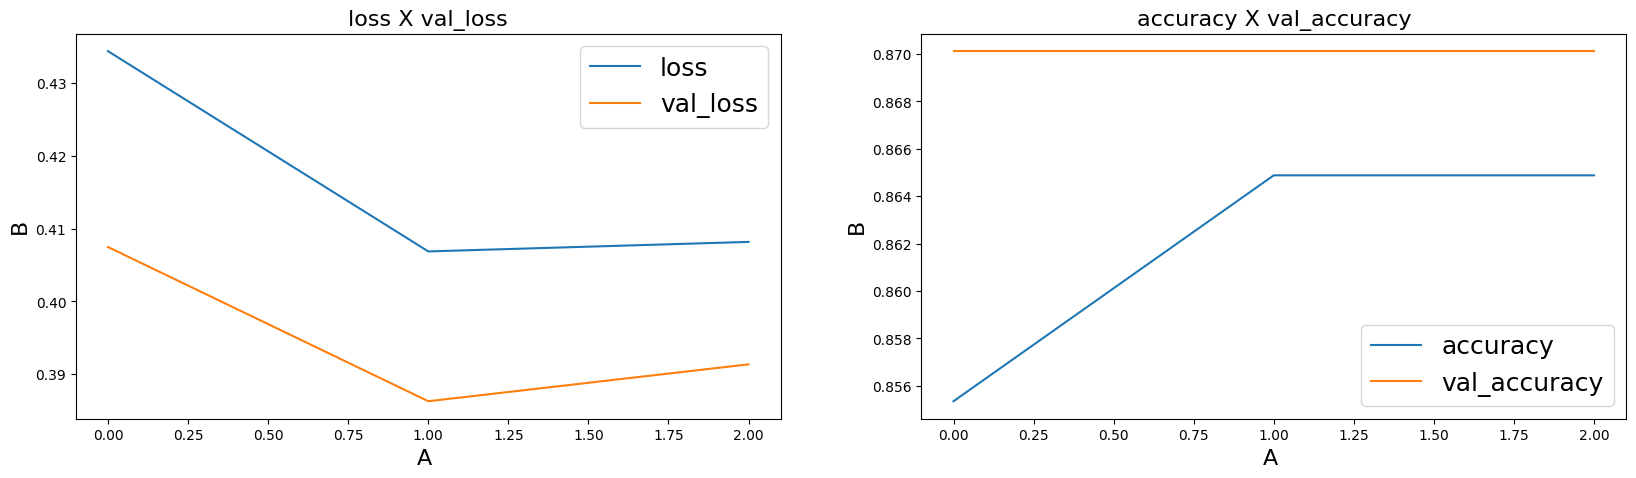

In [ ]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])